<a href="https://colab.research.google.com/github/Biruk-gebru/SVM/blob/main/SVMTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import time
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def load_and_preprocess_data():
    """Load and preprocess MNIST dataset."""
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize and reshape
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    X_train_cnn = np.expand_dims(X_train, -1)
    X_test_cnn = np.expand_dims(X_test, -1)

    # Flatten for SVM
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)

    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"CNN input shape: {X_train_cnn.shape}")
    print(f"SVM input shape: {X_train_flat.shape}")

    return (X_train_cnn, X_test_cnn, X_train_flat, X_test_flat, y_train, y_test)


In [ ]:
def create_cnn_model():
    """Create CNN model."""
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def train_cnn(X_train, y_train, X_test, y_test):
    """Train CNN model."""
    print("Training CNN...")
    model = create_cnn_model()

    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=5, batch_size=64,
                        validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"CNN Test accuracy: {test_acc:.4f}")
    print(f"CNN Training time: {training_time:.2f} seconds")

    return model, test_acc, training_time, history


In [ ]:
def create_feature_extractor(model):
    """Create feature extractor from CNN."""
    # Method A: Reuse existing layer instances on a fresh Input (fast & typical)
    try:
        inp = layers.Input(shape=(28,28,1))
        x = inp
        for layer in model.layers[:-1]:   # exclude final softmax Dense
            x = layer(x)
        feature_extractor = models.Model(inputs=inp, outputs=x)
        print("Method A succeeded: feature_extractor created by re-using layers.")
        return feature_extractor
    except Exception as e:
        print("Method A failed:", repr(e))

        # Method B: Rebuild architecture and copy weights (fallback)
        try:
            inp = layers.Input(shape=(28,28,1))
            x = layers.Conv2D(32, (3,3), activation='relu', name='conv1')(inp)
            x = layers.MaxPooling2D((2,2), name='pool1')(x)
            x = layers.Conv2D(64, (3,3), activation='relu', name='conv2')(x)
            x = layers.MaxPooling2D((2,2), name='pool2')(x)
            x = layers.Flatten(name='flatten')(x)
            x = layers.Dense(64, activation='relu', name='features')(x)

            feature_extractor = models.Model(inputs=inp, outputs=x)
            print("Rebuilt feature_extractor architecture. Now copying weights...")

            # copy weights layer-by-layer (skip input layer in feature_extractor)
            new_layers = [l for l in feature_extractor.layers if len(l.get_weights())>0]
            old_layers = [l for l in model.layers[:-1] if len(l.get_weights())>0]  # exclude final classifier
            for new_l, old_l in zip(new_layers, old_layers):
                try:
                    new_l.set_weights(old_l.get_weights())
                except Exception as we:
                    print(f"Warning: could not set weights for {new_l.name}: {we}")

            print("Method B succeeded: weights copied to rebuilt extractor.")
            return feature_extractor
        except Exception as e2:
            print("Method B failed too:", repr(e2))
            raise RuntimeError("Could not create a feature extractor.")


In [ ]:
def train_cnn_svm(X_train_features, y_train, X_test_features, y_test):
    """Train CNN+SVM model."""
    print("Training CNN+SVM...")

    # Use subset for faster training
    subset_size = 10000
    X_train_small = X_train_features[:subset_size]
    y_train_small = y_train[:subset_size]

    # Grid search for best parameters
    param_grid = {
        'C': [1, 10, 100],
        'gamma': [0.01, 0.1, 0.5],
        'kernel': ['rbf', 'linear']
    }

    start_time = time.time()
    svm = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1, verbose=1)
    svm.fit(X_train_small, y_train_small)
    training_time = time.time() - start_time

    print(f"Best parameters: {svm.best_params_}")
    print(f"Best CV score: {svm.best_score_:.4f}")

    # Predict on test set
    y_pred = svm.predict(X_test_features)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"CNN+SVM test accuracy: {test_acc:.4f}")
    print(f"CNN+SVM Training time: {training_time:.2f} seconds")

    return svm, test_acc, training_time, y_pred


In [ ]:
def train_pure_svm(X_train_flat, y_train, X_test_flat, y_test):
    """Train pure SVM model."""
    print("Training Pure SVM...")

    # Use subset for faster training
    subset_size = 5000
    X_train_small = X_train_flat[:subset_size]
    y_train_small = y_train[:subset_size]

    # Grid search for best parameters
    param_grid = {
        'C': [1, 10, 100],
        'gamma': [0.001, 0.01, 0.1],
        'kernel': ['rbf', 'linear']
    }

    start_time = time.time()
    svm = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1, verbose=1)
    svm.fit(X_train_small, y_train_small)
    training_time = time.time() - start_time

    print(f"Best parameters: {svm.best_params_}")
    print(f"Best CV score: {svm.best_score_:.4f}")

    # Predict on test set
    y_pred = svm.predict(X_test_flat)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Pure SVM test accuracy: {test_acc:.4f}")
    print(f"Pure SVM Training time: {training_time:.2f} seconds")

    return svm, test_acc, training_time, y_pred


In [ ]:
def plot_results(cnn_acc, cnn_svm_acc, svm_acc, cnn_time, cnn_svm_time, svm_time):
    """Plot comparison results."""
    models = ['CNN', 'CNN+SVM', 'Pure SVM']
    accuracies = [cnn_acc, cnn_svm_acc, svm_acc]
    times = [cnn_time, cnn_svm_time, svm_time]
    colors = ['#2E86AB', '#A23B72', '#F18F01']

    plt.figure(figsize=(12, 5))

    # Accuracy comparison
    plt.subplot(1, 2, 1)
    bars = plt.bar(models, accuracies, color=colors)
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0.85, 1.0)
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.3f}', ha='center', va='bottom')

    # Training time comparison
    plt.subplot(1, 2, 2)
    bars = plt.bar(models, times, color=colors)
    plt.title('Training Time Comparison')
    plt.ylabel('Time (seconds)')
    for bar, time_val in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{time_val:.1f}s', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [ ]:
def print_comparison_table(cnn_acc, cnn_svm_acc, svm_acc, cnn_time, cnn_svm_time, svm_time):
    """Print comparison table."""
    results = {
        'Model': ['CNN', 'CNN+SVM', 'Pure SVM'],
        'Test Accuracy': [cnn_acc, cnn_svm_acc, svm_acc],
        'Training Time (s)': [cnn_time, cnn_svm_time, svm_time]
    }

    results_df = pd.DataFrame(results)
    print("\nModel Comparison Results:")
    print(results_df.to_string(index=False))


Enhanced Model Comparison: CNN vs CNN+SVM vs SVM on MNIST
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
CNN input shape: (60000, 28, 28, 1)
SVM input shape: (60000, 784)
Training CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8835 - loss: 0.4011 - val_accuracy: 0.9810 - val_loss: 0.0615
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9828 - loss: 0.0582 - val_accuracy: 0.9848 - val_loss: 0.0469
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9881 - loss: 0.0388 - val_accuracy: 0.9827 - val_loss: 0.0519
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9913 - loss: 0.0286 - val_accuracy: 0.9838 - val_loss: 0.0478
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9940 - loss: 0.0211 - val_accuracy: 0.9873 - val_loss: 0.0390
CNN Test accuracy: 0.9873
CNN Training time: 27.33 seconds

Extracting CNN features...
Method A succeeded: feature_extractor created by re-using layers.
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Feature shapes: (60000, 64), (10000, 64)
Training CNN+SVM...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best param

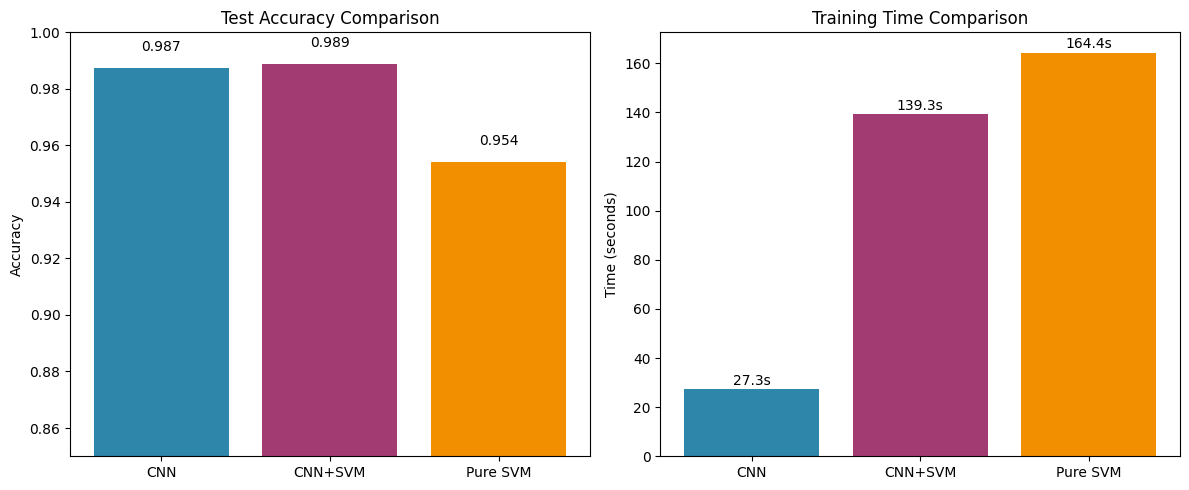


DETAILED ANALYSIS
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       1.00      0.97      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


CNN+SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1

In [ ]:
def main():
    """Main function to run the complete analysis."""
    print("Enhanced Model Comparison: CNN vs CNN+SVM vs SVM on MNIST")
    print("=" * 60)

    # Load data
    X_train_cnn, X_test_cnn, X_train_flat, X_test_flat, y_train, y_test = load_and_preprocess_data()

    # Train CNN
    cnn_model, cnn_acc, cnn_time, cnn_history = train_cnn(X_train_cnn, y_train, X_test_cnn, y_test)

    # Extract features for CNN+SVM
    print("\nExtracting CNN features...")
    feature_extractor = create_feature_extractor(cnn_model)
    X_train_features = feature_extractor.predict(X_train_cnn, batch_size=128, verbose=1)
    X_test_features = feature_extractor.predict(X_test_cnn, batch_size=128, verbose=1)
    print(f"Feature shapes: {X_train_features.shape}, {X_test_features.shape}")

    # Train CNN+SVM
    cnn_svm_model, cnn_svm_acc, cnn_svm_time, cnn_svm_pred = train_cnn_svm(
        X_train_features, y_train, X_test_features, y_test)

    # Train Pure SVM
    svm_model, svm_acc, svm_time, svm_pred = train_pure_svm(
        X_train_flat, y_train, X_test_flat, y_test)

    # Print results
    print_comparison_table(cnn_acc, cnn_svm_acc, svm_acc, cnn_time, cnn_svm_time, svm_time)

    # Plot results
    plot_results(cnn_acc, cnn_svm_acc, svm_acc, cnn_time, cnn_svm_time, svm_time)

    # Print detailed reports
    print("\n" + "="*60)
    print("DETAILED ANALYSIS")
    print("="*60)

    # CNN predictions
    y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

    print("\nCNN Classification Report:")
    print(classification_report(y_test, y_pred_cnn))

    print("\nCNN+SVM Classification Report:")
    print(classification_report(y_test, cnn_svm_pred))

    print("\nPure SVM Classification Report:")
    print(classification_report(y_test, svm_pred))

if __name__ == "__main__":
    main()